https://github.com/lyst/lightfm/blob/master/examples/movielens/example.ipynb

In [1]:
import numpy as np

#サンプルデータ
from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

C:\Users\ryou\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
#含まれるデータを確認
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [3]:
train = movielens["train"]
test = movielens["test"]

In [4]:
from lightfm import LightFM
#上位k個だけのprecison
from lightfm.evaluation import precision_at_k
#AUC
from lightfm.evaluation import auc_score

#レコメンドリストの上のほうだけじゃなくて全体をよくしたい（precision@kよりもAUCを良くしたい）ときはBPR
model = LightFM(learning_rate = 0.05, loss = "bpr")
model.fit(train, epochs = 10)

train_precision = precision_at_k(model, train, k = 10).mean()
test_precision = precision_at_k(model, test, k = 10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print("Precision: train %.2f, test %.2f" % (train_precision, test_precision))
print("AUC: train %.2f, test %.2f" % (train_auc, test_auc))

Precision: train 0.59, test 0.10
AUC: train 0.90, test 0.86


In [5]:
#レコメンドリストの上のほうだけよくしたい（precision@kを良くしたい）ときはWARP
model = LightFM(learning_rate = 0.05, loss = "warp")

model.fit_partial(train, epochs = 10)

train_precision = precision_at_k(model, train, k = 10).mean()
test_precision = precision_at_k(model, test, k = 10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print("Precision: train %.2f, test %.2f" % (train_precision, test_precision))
print("AUC: train %.2f, test %.2f" % (train_auc, test_auc))

Precision: train 0.60, test 0.11
AUC: train 0.94, test 0.90


******************************

adagrad と adadelta のちがい
https://github.com/lyst/lightfm/blob/master/examples/movielens/learning_schedules.ipynb

In [6]:
import numpy as np
import data

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens["train"], movielens["test"]

In [7]:
alpha = 1e-3
epochs = 70

#モデルの比較 loss関数をWARPでやってみる

adagrad_model = LightFM(no_components = 30,
                       loss = "warp",
                       learning_schedule = "adagrad", 
                       user_alpha = alpha, 
                       item_alpha = alpha)

adadelta_model = LightFM(no_components = 30,
                       loss = "warp",
                       learning_schedule = "adadelta", 
                       user_alpha = alpha, 
                       item_alpha = alpha)

adagrad_auc = []
adadelta_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs = 1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs = 1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

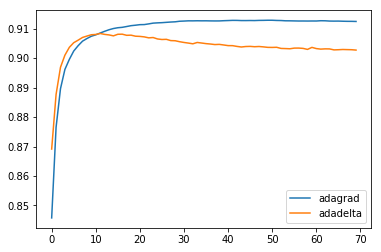

In [9]:
x = np.arange(len(adagrad_auc))

plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(["adagrad", "adadelta"], loc = "lower right")
plt.show()

In [10]:
alpha = 1e-3
epochs = 70

#モデルの比較 loss関数をk-OSでやってみる

adagrad_model = LightFM(no_components = 30,
                       loss = "warp-kos",
                       learning_schedule = "adagrad", 
                       user_alpha = alpha, 
                       item_alpha = alpha)

adadelta_model = LightFM(no_components = 30,
                       loss = "warp-kos",
                       learning_schedule = "adadelta", 
                       user_alpha = alpha, 
                       item_alpha = alpha)

adagrad_auc = []
adadelta_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs = 1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs = 1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

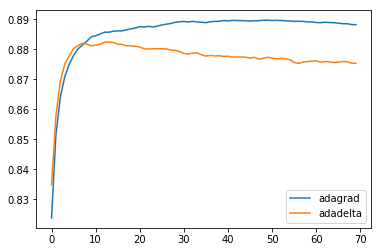

In [11]:
x = np.arange(len(adagrad_auc))

plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(["adagrad", "adadelta"], loc = "lower right")
plt.show()

***************

https://github.com/lyst/lightfm/blob/master/examples/movielens/warp_loss.ipynb

In [14]:
import time

import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

In [15]:
alpha = 1e-05
epochs = 70
num_components = 32

#loss関数をWARPとBPRにしたときそれぞれのAUCの推移をみる

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

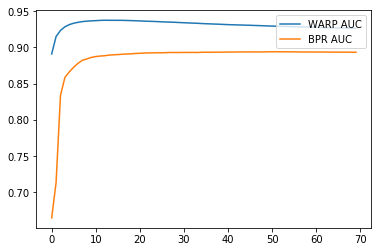

In [16]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

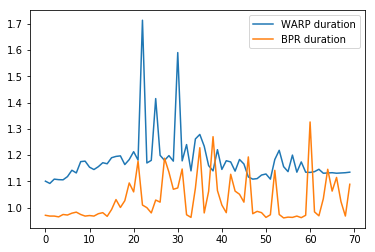

In [17]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

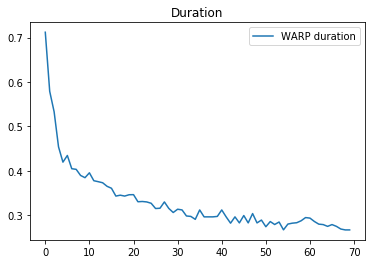

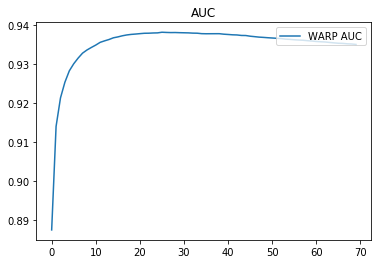

In [18]:
#max_sampledを調整するとWARPでもそれなりにはやくなるらしい
warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()